## 1. SET-UP

In [2]:
import pandas as pd
import json
import os

In [3]:
# 1. Load JSON files for each term
def load_mep_data(json_path):
    """Load MEP data from a JSON file."""
    print(f"Loading MEP data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"File not found: {json_path}")
        exit(1)
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            file_content = f.read().strip()  # Strip any extra whitespace
            if not file_content:
                raise ValueError("File is empty")
            
            # Validate JSON by loading
            meps_data = json.loads(file_content)  
            print(f"Loaded {len(meps_data)} MEPs successfully.")
            return meps_data
    
    except json.JSONDecodeError as e:
        print(f"JSON decode error at character {e.pos}: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Failed to load MEP data: {e}")
    exit(1)

# File paths (replace with your paths)
data_9th_term = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json')
data_10th_term = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json')

# Convert data to DataFrame
df_9th = pd.json_normalize(data_9th_term)
df_9th['term'] = 9  # Add term info
df_10th = pd.json_normalize(data_10th_term)
df_10th['term'] = 10

# Concatenate dataframes
all_meps = pd.concat([df_9th, df_10th], ignore_index=True)
print(all_meps)

Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json
Loaded 735 MEPs successfully.
Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json
Loaded 719 MEPs successfully.
                            name  \
0                Abir AL-SAHLANI   
1                    Adam BIELAN   
2                   Adam JARUBAS   
3             Adina-Ioana VĂLEAN   
4            Adrian-Dragoş BENEA   
...                          ...   
1449           Nicola ZINGARETTI   
1450             Kosma ZŁOTOWSKI   
1451  Juan Ignacio ZOIDO ÁLVAREZ   
1452               Željana ZOVKO   
1453                  Milan ZVER   

                                                  party   country  \
0                                    Renew Europe Group    Sweden   
1           European Conservatives and Reformists Group    Poland  

In [4]:
SANITY_CHECK_9TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json')
SANITY_CHECK_10TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json')

# Initialize a dictionary to count assistants
party_assistant_counts = {}

# Iterate over each entry in the JSON data
for entry in SANITY_CHECK_10TERM:
    party = entry["party"]
    assistants = entry.get("assistants", {})
    
    # Count accredited assistants
    accredited_count = len(assistants.get("Accredited assistants", []))
    accredited_grouping_count = len(assistants.get("Accredited assistants (grouping)", []))
    
    # Update the count in the party_assistant_counts dictionary
    if party not in party_assistant_counts:
        party_assistant_counts[party] = {
            "Accredited assistants": 0,
            "Accredited assistants (grouping)": 0
        }
    
    party_assistant_counts[party]["Accredited assistants"] += accredited_count
    party_assistant_counts[party]["Accredited assistants (grouping)"] += accredited_grouping_count

# Print the results
for party, counts in party_assistant_counts.items():
    print(f"Party: {party}")
    print(f"  Accredited assistants: {counts['Accredited assistants']}")
    print(f"  Accredited assistants (grouping): {counts['Accredited assistants (grouping)']}")

Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json
Loaded 735 MEPs successfully.
Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json
Loaded 719 MEPs successfully.
Party: Group of the European People's Party (Christian Democrats)
  Accredited assistants: 479
  Accredited assistants (grouping): 689
Party: Renew Europe Group
  Accredited assistants: 208
  Accredited assistants (grouping): 107
Party: Group of the Progressive Alliance of Socialists and Democrats in the European Parliament
  Accredited assistants: 274
  Accredited assistants (grouping): 1172
Party: European Conservatives and Reformists Group
  Accredited assistants: 166
  Accredited assistants (grouping): 58
Party: Non-attached Members
  Accredited assistants: 59
  Accredited assistants (grouping): 22
Party: Europe of Sovereign N

In [5]:
# keep only columns that we will use in analysis
columns_to_keep = [
    'name', 
    'party', 
    'country', 
    'term', 
    'assistants.Accredited assistants', 
    'assistants.Accredited assistants (grouping)'
]

# filter the DataFrame
meps_apas = all_meps[columns_to_keep]

# rename the columns by removing the 'assistants.' prefix
meps_apas.columns = [col.replace('assistants.', '') for col in meps_apas.columns]

# 2. CLEAN & STANDARDIZE

### 2.1 Party names to abbreviations

In [6]:
# Create a mapping dictionary for party names to abbreviations
party_abbreviations = {
    'Renew Europe Group': 'Renew',
    'European Conservatives and Reformists Group': 'ECR',
    "Group of the European People's Party (Christian Democrats)": 'EPP',
    'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament': 'S&D',
    'Identity and Democracy Group': 'ID',
    'Group of the Greens/European Free Alliance': 'G/EFA',
    'Confederal Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Non-attached Members': 'NA',
    'The Left group in the European Parliament - GUE/NGL': 'GUE/NGL',
    'Group of the European United Left - Nordic Green Left': 'GUE/NGL',
    'Patriots for Europe Group': 'PFE',
    'Europe of Sovereign Nations Group': 'ESN'
}

meps_apas.loc[:, 'group_abbrv'] = meps_apas['party'].map(party_abbreviations)
#print(meps_apas['party'].unique())
#print(meps_apas['group_abbrv'].unique())


C:\Users\Emilia\AppData\Local\Temp\ipykernel_22260\4283556260.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meps_apas.loc[:, 'group_abbrv'] = meps_apas['party'].map(party_abbreviations)


### 2.3 Flatten & pivot (assistants are row level)

In [7]:
# Function to extract relevant assistants with type information
def extract_assistants(row):
    assistants = []
    # Define relevant groups and their corresponding types
    assistant_groups = {
        'Accredited assistants': 'accredited',
        'Accredited assistants (grouping)': 'accredited_grouping'
    }
    
    for group, assistant_type in assistant_groups.items():
        # Check if the group exists in the row and is a list
        if group in row and isinstance(row[group], list):
            for name in row[group]:
                assistants.append({
                    'assistant_name': name,
                    'mep_name': row['name'],
                    'group': row['group_abbrv'],
                    'country': row['country'],
                    'term': row['term'],
                    'assistant_type': assistant_type  # Add assistant type
                })
    return assistants

# Flatten assistants for easier comparison
assistant_data = pd.DataFrame(
    [item for sublist in meps_apas.apply(extract_assistants, axis=1) for item in sublist]
)
print(assistant_data)

                         assistant_name         mep_name  group   country  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI  Renew    Sweden   
1               John August HULTENGAARD  Abir AL-SAHLANI  Renew    Sweden   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI  Renew    Sweden   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI  Renew    Sweden   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS    EPP    Poland   
...                                 ...              ...    ...       ...   
7495          Andréa Laure Marie MOULIN    Željana ZOVKO    EPP   Croatia   
7496                         Polona KEK       Milan ZVER    EPP  Slovenia   
7497                     Petra SKRINJAR       Milan ZVER    EPP  Slovenia   
7498                        Peter SUHEL       Milan ZVER    EPP  Slovenia   
7499                     Dominik STRAKL       Milan ZVER    EPP  Slovenia   

      term       assistant_type  
0        9           accredited  
1      

### 2.3 Remove duplicate assistant names in same term

In [8]:
# FIRST REMAP THE NAMES
from fuzzywuzzy import fuzz

def find_similar_names(df, same_term=True):
    similar_pairs = []

    # Iterate through each MEP
    for mep in df['mep_name'].unique():
        # Filter for the current MEP
        if same_term:
            mep_data = df[df['mep_name'] == mep]
        else:
            mep_data = df[df['mep_name'] == mep]  # No term filter for this case

        names = mep_data['assistant_name'].tolist()

        # Check for similarity between each pair of assistant names
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                # Calculate similarity score
                score = fuzz.ratio(names[i].lower(), names[j].lower())
                
                # Adjusting the threshold between 90 and 99
                if 85 <= score < 100:  # Use the desired range here
                    similar_pairs.append((names[i], names[j], mep))

    return similar_pairs

# create remapping based on similar names
name_mapping = {
    "Magdalena NOWACKA": "Magdalena HILLS-NOWACKA", 
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Eleonora Nikolaycheva GUIGOVA": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Eleonora Nikolaycheva GUIGOVA-NOSKER": "Eleonora Nikolaycheva GUIGOVA-NOSKER",
    "Stefanie SIFFT": "Stefanie SIFFT",
    "Stefanie Gabi SIFFT": "Stefanie SIFFT",
    "Anne-Cecile Juliette GAULT": "Anne-Cecile Juliette GAULT",
    "Anne-Cecile Juliette Rachel GAULT": "Anne-Cecile Juliette GAULT",
    "Sophie Anne Geraldine Marie GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Sophie Anne Geraldine Marie Genevieve GUIL": "Sophie Anne Geraldine Marie GUIL",
    "Ana LOPEZ GONZALEZ": "ANA LÓPEZ GONZÁLEZ",
    "ANA LÓPEZ GONZÁLEZ": "ANA LÓPEZ GONZÁLEZ",
    "Claudia MARTINEZ MUNOZ": "Claudia MARTÍNEZ MUÑOZ",
    "CLAUDIA MARTÍNEZ MUÑOZ": "Claudia MARTÍNEZ MUÑOZ",
    "Maria Mercedes GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "MARIA MERCEDES GARCIA MUÑOZ": "MARIA MERCEDES GARCIA MUÑOZ",
    "Gilles Willy B SEGERS": "GILLES WILLY SEGERS",
    "GILLES WILLY SEGERS": "GILLES WILLY SEGERS",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Maria Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "Arturo VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "Fernando Jose NUNEZ ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Fernando Jose NUNEZ-ROBRES PATINO": "Fernando Jose NUNEZ-ROBRES PATINO",
    "Bibiana CARRETO PEREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "BIBIANA CARRETO PÉREZ BARBADILLO": "BIBIANA CARRETO PÉREZ BARBADILLO",
    "Magdalena GONZALEZ GOZALBO": "Maria Magdalena GONZALEZ GOZALBO",
    "PAULA SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "Paula SENDIN RODRIGUEZ": "Paula SENDÍN RODRIGUEZ",
    "MARIA MERCEDES GARCIA MUNOZ": "MARIA MERCEDES GARCIA MUÑOZ", 
    "ARTURO VILLARROYA GONZALEZ": "Arturo VILLARROYA GONZÁLEZ",
    "ARTURO VILLARROYA GONZALEZ":"Arturo VILLARROYA GONZÁLEZ"
}

# remap 
assistant_data['assistant_name'] = assistant_data['assistant_name'].replace(name_mapping)

# Find similar names considering only the same term
similar_names_same_term = find_similar_names(assistant_data, same_term=True)
print("Similar assistant names for the same MEP in the same term:")
for name1, name2, mep in similar_names_same_term:
    print(f"{name1} and {name2} for {mep} are similar.")

print(assistant_data)

Similar assistant names for the same MEP in the same term:
Michal MOJTO and Michaela MOJTOVÁ for Monika BEŇOVÁ are similar.
Michal MOJTO and Michaela MOJTOVÁ for Monika BEŇOVÁ are similar.
Michal MOJTO and Michaela MOJTOVÁ for Erik KALIŇÁK are similar.
                         assistant_name         mep_name  group   country  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI  Renew    Sweden   
1               John August HULTENGAARD  Abir AL-SAHLANI  Renew    Sweden   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI  Renew    Sweden   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI  Renew    Sweden   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS    EPP    Poland   
...                                 ...              ...    ...       ...   
7495          Andréa Laure Marie MOULIN    Željana ZOVKO    EPP   Croatia   
7496                         Polona KEK       Milan ZVER    EPP  Slovenia   
7497                     Petra SKRINJAR       Milan ZV

In [9]:
# THEN REMOVE ANY EXACT MATCHES 
# Find exact matches within each MEP category
# Find exact matches within each MEP and term
def find_exact_matches(df):
    exact_matches = {}

    # Group by 'mep_name' and 'term' and find duplicates in 'remapped_name'
    for (mep, term), group in df.groupby(['mep_name', 'term']):
        duplicates = group['assistant_name'].value_counts()
        # Only keep names that occur more than once
        duplicate_names = duplicates[duplicates > 1].index.tolist()
        
        if duplicate_names:
            exact_matches[(mep, term)] = duplicate_names

    return exact_matches

# Get exact matches
exact_matches = find_exact_matches(assistant_data)

# Print out exact matches
#print("Exact matches in MEP categories (for the same term):")
#for (mep, term), names in exact_matches.items():
#    print(f"\nMEP: {mep} | Term: {term}")
#    for name in names:
#        print(f" - {name}")

# remove duplicates 
unique_meps_apas = assistant_data.drop_duplicates(subset=['mep_name', 'term', 'assistant_name'])
print(unique_meps_apas)


                         assistant_name         mep_name  group   country  \
0                 Anna Sophia BENGTSSON  Abir AL-SAHLANI  Renew    Sweden   
1               John August HULTENGAARD  Abir AL-SAHLANI  Renew    Sweden   
2                  Tyra Louise LUNDBERG  Abir AL-SAHLANI  Renew    Sweden   
3     Linn Christina Brunhilde OETTERLI  Abir AL-SAHLANI  Renew    Sweden   
4               Sylwia Joanna BETKOWSKA     Adam JARUBAS    EPP    Poland   
...                                 ...              ...    ...       ...   
7495          Andréa Laure Marie MOULIN    Željana ZOVKO    EPP   Croatia   
7496                         Polona KEK       Milan ZVER    EPP  Slovenia   
7497                     Petra SKRINJAR       Milan ZVER    EPP  Slovenia   
7498                        Peter SUHEL       Milan ZVER    EPP  Slovenia   
7499                     Dominik STRAKL       Milan ZVER    EPP  Slovenia   

      term       assistant_type  
0        9           accredited  
1      

# 3. Summary Tables

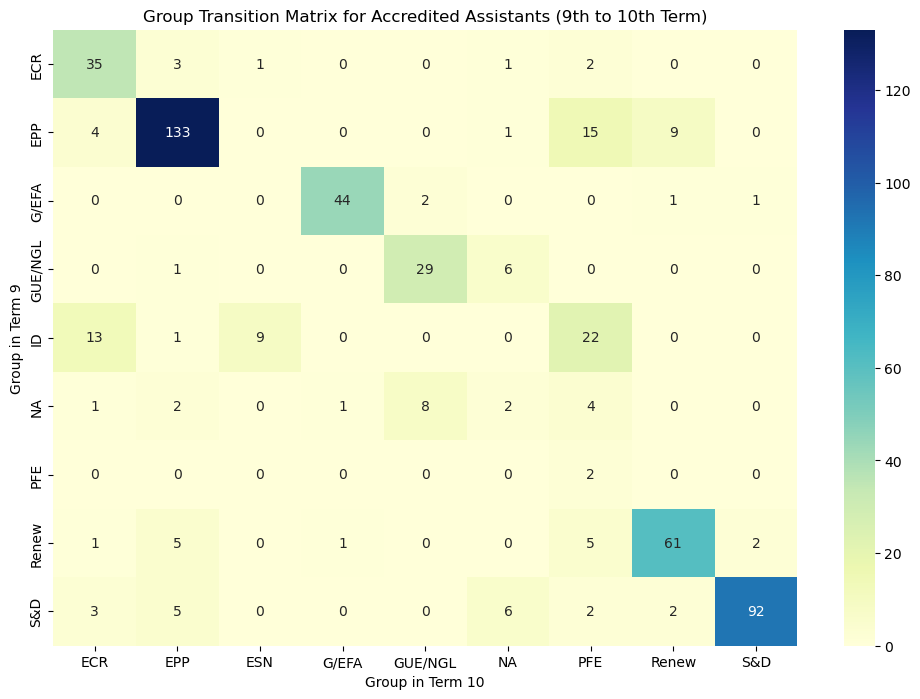

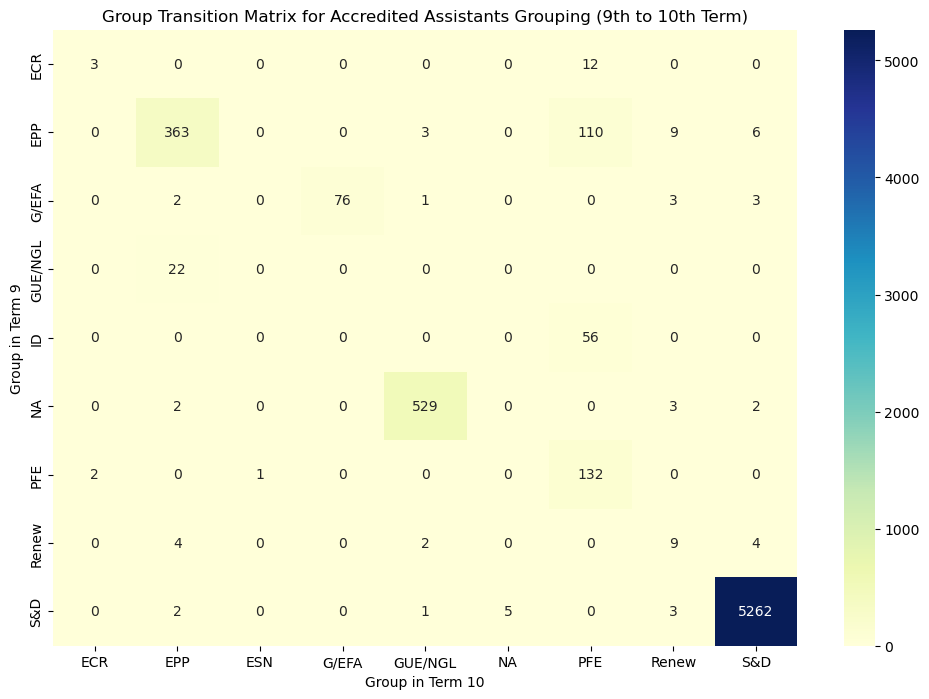

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for terms 9 and 10
term_data = unique_meps_apas[unique_meps_apas['term'].isin([9, 10])]

# Function to create transition matrix for a specific assistant type
def create_transition_matrix(assistant_type):
    # Step 1: Filter for the specific assistant type
    filtered_data = term_data[term_data['assistant_type'] == assistant_type]
    
    # Step 2: Get assistants for term 9 and term 10
    term_9 = filtered_data[filtered_data['term'] == 9]
    term_10 = filtered_data[filtered_data['term'] == 10]

    # Step 3: Merge both DataFrames on assistant_name
    merged = term_9[['assistant_name', 'group']].merge(term_10[['assistant_name', 'group']], on='assistant_name', suffixes=('_9', '_10'))

    # Step 4: Count transitions from term 9 to term 10
    transition_counts = merged.groupby(['group_9', 'group_10']).size().reset_index(name='counts')

    # Step 5: Create a transition matrix
    transition_matrix = transition_counts.pivot(index='group_9', columns='group_10', values='counts').fillna(0)

    # Optional: Convert counts to integers if needed
    transition_matrix = transition_matrix.astype(int)

    return transition_matrix

# Create transition matrices for both types of assistants
accredited_transition_matrix = create_transition_matrix('accredited')
accredited_grouping_transition_matrix = create_transition_matrix('accredited_grouping')

# Visualization of the Transition Matrix for Accredited Assistants
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Group Transition Matrix for Accredited Assistants (9th to 10th Term)')
plt.xlabel('Group in Term 10')
plt.ylabel('Group in Term 9')
plt.show()

# Visualization of the Transition Matrix for Accredited Assistants Grouping
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_grouping_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Group Transition Matrix for Accredited Assistants Grouping (9th to 10th Term)')
plt.xlabel('Group in Term 10')
plt.ylabel('Group in Term 9')
plt.show()

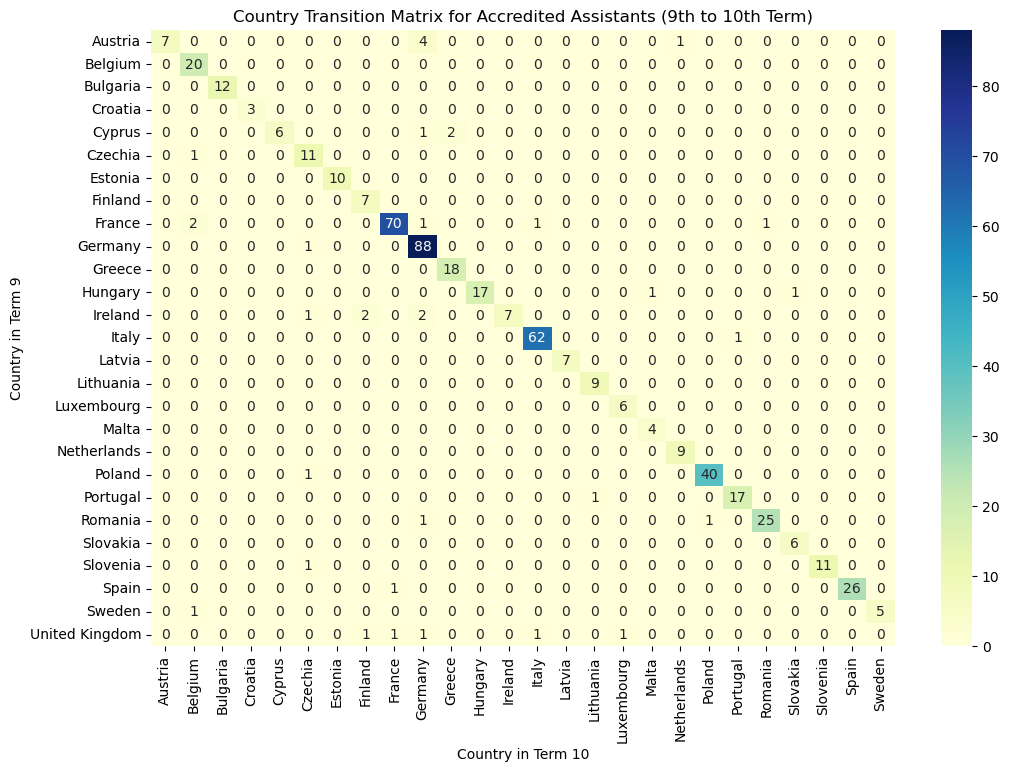

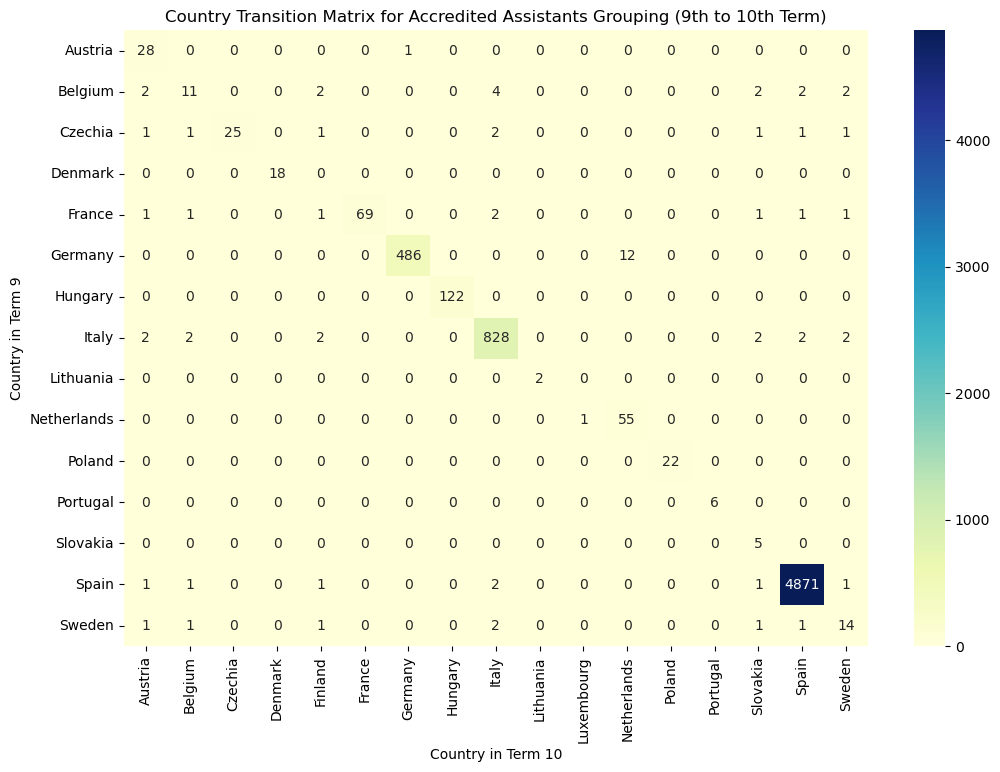

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for terms 9 and 10
term_data = unique_meps_apas[unique_meps_apas['term'].isin([9, 10])]

# Function to create country transition matrix for a specific assistant type
def create_country_transition_matrix(assistant_type):
    # Step 1: Filter for the specific assistant type
    filtered_data = term_data[term_data['assistant_type'] == assistant_type]
    
    # Step 2: Get assistants for term 9 and term 10
    term_9 = filtered_data[filtered_data['term'] == 9]
    term_10 = filtered_data[filtered_data['term'] == 10]

    # Step 3: Merge both DataFrames on assistant_name
    merged = term_9[['assistant_name', 'country']].merge(term_10[['assistant_name', 'country']], on='assistant_name', suffixes=('_9', '_10'))

    # Step 4: Count transitions from term 9 to term 10
    transition_counts = merged.groupby(['country_9', 'country_10']).size().reset_index(name='counts')

    # Step 5: Create a transition matrix
    transition_matrix = transition_counts.pivot(index='country_9', columns='country_10', values='counts').fillna(0)

    # Optional: Convert counts to integers if needed
    transition_matrix = transition_matrix.astype(int)

    return transition_matrix

# Create transition matrices for both types of assistants
accredited_country_transition_matrix = create_country_transition_matrix('accredited')
accredited_grouping_country_transition_matrix = create_country_transition_matrix('accredited_grouping')

# Visualization of the Transition Matrix for Accredited Assistants
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_country_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Country Transition Matrix for Accredited Assistants (9th to 10th Term)')
plt.xlabel('Country in Term 10')
plt.ylabel('Country in Term 9')
plt.show()

# Visualization of the Transition Matrix for Accredited Assistants Grouping
plt.figure(figsize=(12, 8))
sns.heatmap(accredited_grouping_country_transition_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Country Transition Matrix for Accredited Assistants Grouping (9th to 10th Term)')
plt.xlabel('Country in Term 10')
plt.ylabel('Country in Term 9')
plt.show()

### 3.1 Summary of movement (b/w MEPs that were in both 9th and 10th term)

#### 3.1.1 Sanity Check

In [12]:
# Load data for both terms
SANITY_CHECK_9TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json')
SANITY_CHECK_10TERM = load_mep_data('C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json')

# Initialize a dictionary to count total assistants
total_assistant_counts = {}

# Function to count assistants from the data
def count_assistants(data, term):
    for entry in data:
        party = entry["party"]
        assistants = entry.get("assistants", {})
        
        # Count accredited assistants
        accredited_count = len(assistants.get("Accredited assistants", [])) + len(assistants.get("Accredited assistants (grouping)", []))
        
        # Initialize party in dictionary if not already present
        if party not in total_assistant_counts:
            total_assistant_counts[party] = {"term_9": 0, "term_10": 0}
        
        # Update the count for the respective term
        if term == 9:
            total_assistant_counts[party]["term_9"] += accredited_count
        elif term == 10:
            total_assistant_counts[party]["term_10"] += accredited_count

# Count assistants for both terms
count_assistants(SANITY_CHECK_9TERM, term=9)
count_assistants(SANITY_CHECK_10TERM, term=10)

# Debugging: Print total assistants for each party
for party, counts in total_assistant_counts.items():
    print(f"Party: {party}, Term 9: {counts['term_9']}, Term 10: {counts['term_10']}")

Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/9 term/raw data/final/9TERM_ALL_STANDARDIZED.json
Loaded 735 MEPs successfully.
Loading MEP data from: C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/assistant task/10 term/raw data/29-10-2024/mep_assistants.json
Loaded 719 MEPs successfully.
Party: Renew Europe Group, Term 9: 310, Term 10: 315
Party: European Conservatives and Reformists Group, Term 9: 143, Term 10: 224
Party: Group of the European People's Party (Christian Democrats), Term 9: 751, Term 10: 1168
Party: Group of the Progressive Alliance of Socialists and Democrats in the European Parliament, Term 9: 1281, Term 10: 1446
Party: Identity and Democracy Group, Term 9: 139, Term 10: 0
Party: Group of the Greens/European Free Alliance, Term 9: 318, Term 10: 365
Party: Confederal Group of the European United Left - Nordic Green Left, Term 9: 49, Term 10: 0
Party: Non-attached Members, Term 9: 150, Term 10: 81


#### 3.1.2 Calculation

In [13]:
# Filter the DataFrame for terms 9 and 10
term_9 = unique_meps_apas[unique_meps_apas['term'] == 9]
term_10 = unique_meps_apas[unique_meps_apas['term'] == 10]

# Group by MEP and group for each term to count assistants, ensuring unique combinations
term_9_grouped = term_9.groupby(['mep_name', 'group']).agg(assistant_count_9=('assistant_name', 'count')).reset_index()
term_10_grouped = term_10.groupby(['mep_name', 'group']).agg(assistant_count_10=('assistant_name', 'count')).reset_index()

# Merge the two dataframes on MEP name and group to create a transition table
transition_df = pd.merge(term_9_grouped, term_10_grouped, on=['mep_name', 'group'], how='outer')

# Create transition summary
transition_summary = []

# Loop through unique groups in term 9
for group_9 in transition_df['group'].unique():
    group_9_assistants = transition_df[transition_df['group'] == group_9]
    
    # Loop through unique groups in term 10
    for group_10 in transition_df['group'].unique():
        # Count how many moved from group_9 to group_10
        count = group_9_assistants['assistant_count_9'].sum() if (group_9_assistants['assistant_count_10'] > 0).any() else 0
        transition_summary.append({
            'group_9': group_9,
            'group_10': group_10,
            'counts': count
        })

# Remove rows with NaN in either assistant_count_9 or assistant_count_10
transition_df = transition_df.dropna(subset=['assistant_count_9', 'assistant_count_10'])

# Step 1: Calculate total assistants for each group in both terms
total_assistants_term_9 = transition_df.groupby('group')['assistant_count_9'].sum().reset_index()
total_assistants_term_9.rename(columns={'assistant_count_9': 'total_assistants_9'}, inplace=True)

total_assistants_term_10 = transition_df.groupby('group')['assistant_count_10'].sum().reset_index()
total_assistants_term_10.rename(columns={'assistant_count_10': 'total_assistants_10'}, inplace=True)

# Step 2: Merge the totals into a single DataFrame
total_assistants = pd.merge(total_assistants_term_9, total_assistants_term_10, on='group', how='outer')

# Step 3: Calculate the difference and the proportion
total_assistants['assistant_difference'] = total_assistants['total_assistants_9'] - total_assistants['total_assistants_10']
total_assistants['proportion_difference'] = total_assistants['assistant_difference'] / total_assistants['total_assistants_9']

# Handle division by zero
total_assistants['proportion_difference'] = total_assistants.apply(
    lambda row: row['proportion_difference'] if row['total_assistants_9'] > 0 else None, axis=1
)

# Display the results
print(total_assistants[['group', 'total_assistants_9', 'total_assistants_10', 'assistant_difference', 'proportion_difference']])


     group  total_assistants_9  total_assistants_10  assistant_difference  \
0      ECR                51.0                 74.0                 -23.0   
1      EPP               444.0                614.0                -170.0   
2    G/EFA               170.0                206.0                 -36.0   
3  GUE/NGL                45.0                 41.0                   4.0   
4       NA                 4.0                  7.0                  -3.0   
5      PFE                63.0                 52.0                  11.0   
6    Renew               121.0                150.0                 -29.0   
7      S&D               802.0                715.0                  87.0   

   proportion_difference  
0              -0.450980  
1              -0.382883  
2              -0.211765  
3               0.088889  
4              -0.750000  
5               0.174603  
6              -0.239669  
7               0.108479  


#### 3.1.3 Plotting

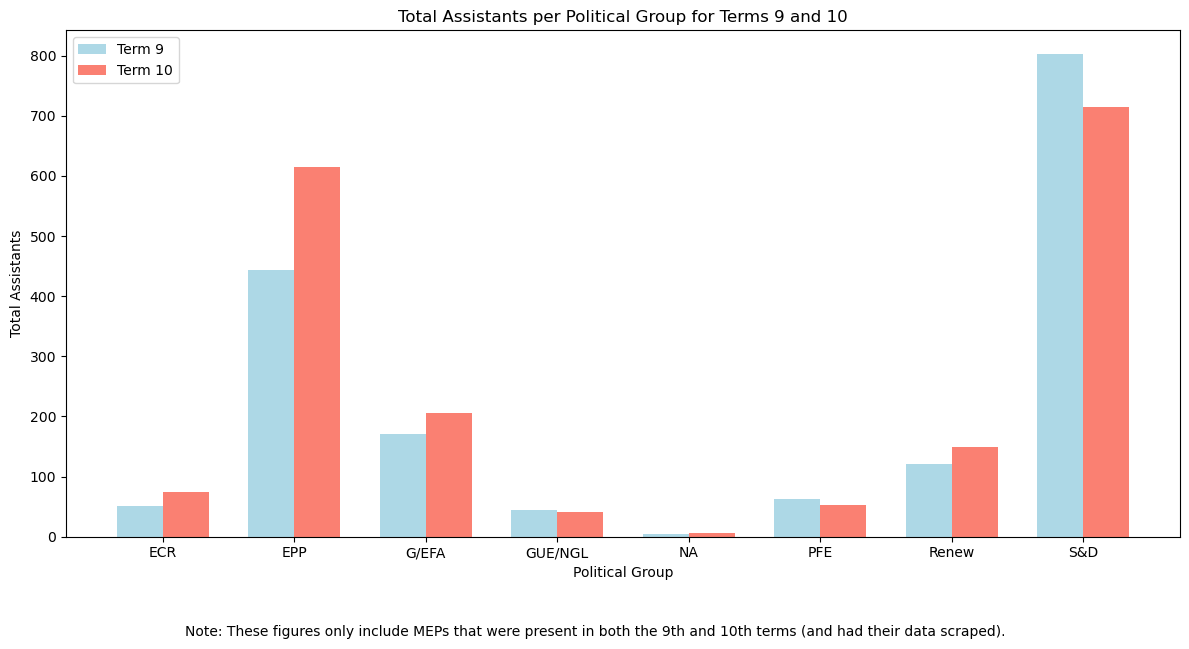

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `group_data`
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(total_assistants))

# Create the bars
plt.bar(x, total_assistants['total_assistants_9'], width=bar_width, label='Term 9', color='lightblue')
plt.bar([p + bar_width for p in x], total_assistants['total_assistants_10'], width=bar_width, label='Term 10', color='salmon')

# Add labels and title
plt.xlabel('Political Group')
plt.ylabel('Total Assistants')
plt.title('Total Assistants per Political Group for Terms 9 and 10')
plt.xticks([p + bar_width / 2 for p in x], total_assistants['group'])
plt.legend()

# Add footnote using fig.text()
plt.gcf().text(0.5, -0.05, 
                'Note: These figures only include MEPs that were present in both the 9th and 10th terms (and had their data scraped).',
                ha='center', fontsize=10, color='black', va='top')

# Show the plot
plt.tight_layout()
plt.show()

## 4. Create Network Graph

In [15]:
import networkx as nx
import plotly.graph_objects as go
import pandas as pd

# Sample Data: Replace with your actual DataFrame
# Assume `unique_meps_apas` is your DataFrame with MEPs and assistants data
# Here, the structure is: ['mep_name', 'assistant_name', 'group']

# Create a directed graph
G = nx.Graph()

# Define a color map for groups
group_colors = {
    'EPP': 'blue', 'S&D': 'red', 'Renew': 'yellow', 'Greens/EFA': 'green', 
    'ID': 'purple', 'ECR': 'orange', 'GUE/NGL': 'pink', 'NI': 'gray'
}

# Sample MEPs to visualize (You can use all unique MEPs or a subset)
sample_meps = unique_meps_apas['mep_name'].unique()[:20]  
sample_data = unique_meps_apas[unique_meps_apas['mep_name'].isin(sample_meps)]

# Create a dictionary to track assistant counts for each MEP
assistant_count = {}

# Add nodes and edges based on the filtered data
for _, row in sample_data.iterrows():
    mep_name = row['mep_name']
    assistant_name = row['assistant_name']
    group = row['group']
    
    # Add MEP node with group color
    G.add_node(mep_name, type='mep', group=group, color=group_colors.get(group, 'black'))
    
    # Count assistants per MEP for sizing
    if mep_name in assistant_count:
        assistant_count[mep_name] += 1
    else:
        assistant_count[mep_name] = 1
    
    # Add edge between MEP and assistant (not needed for this visualization)
    G.add_node(assistant_name, type='assistant', color='lightgray')
    G.add_edge(mep_name, assistant_name)

# Create positions for the nodes using spring layout
pos = nx.spring_layout(G, seed=42)  # Use seed for reproducibility

# Function to format the text for MEP nodes
def format_mep_text(mep_name, count):
    if count > 1:
        # Split the name into two rows if possible
        return f"{mep_name}\n(Assistants: {count})"
    return mep_name

# Add nodes with customized sizes and colors
node_x = []
node_y = []
node_text = []
node_hover_text = []
node_size = []
node_color = []

for node in G.nodes(data=True):
    x, y = pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    
    if node[1]['type'] == 'mep':
        # Set MEP node size based on the number of assistants they have
        count = assistant_count.get(node[0], 0)
        node_size.append(5 + count * 3)  # Base size plus scaling factor
        node_color.append(node[1]['color'])
        
        # Format text for the node (two lines if space allows)
        formatted_text = format_mep_text(node[0], count)
        node_text.append(formatted_text)  # Show formatted text on node
        node_hover_text.append(node[0])  # Show full name on hover
    else:
        node_size.append(0)  # Hide assistant nodes from visualization
        node_color.append('lightgray')
        node_text.append('')  # No text for assistants
        node_hover_text.append('')  # No hover text for assistants

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=node_color,
        line=dict(width=2)
    )
)

# Create the figure with a legend
fig = go.Figure(data=[node_trace],
                layout=go.Layout(
                    title='MEP Assistants Network Graph',
                    titlefont=dict(size=16),
                    showlegend=True,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Create legend
for group, color in group_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None], 
        mode='markers', 
        marker=dict(size=10, color=color),
        name=group  # Name of the group to show in the legend
    ))

# Show the plot
fig.show()

In [16]:
import networkx as nx
import json

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with group, term, and assistant_type as attributes
for _, row in unique_meps_apas.iterrows():
    # Add MEP nodes
    G.add_node(
        row['mep_name'], 
        type='mep', 
        group=row['group'], 
        term=row['term']
    )
    
    # Add assistant nodes with assistant_type
    G.add_node(
        row['assistant_name'], 
        type='assistant', 
        group=None, 
        term=None, 
        assistant_type=row.get('assistant_type')  # Ensure this attribute is populated
    )
    
    # Create edge between MEP and assistant
    G.add_edge(row['mep_name'], row['assistant_name'])

# Convert the graph to JSON format
graph_data = {
    "nodes": [
        {
            "id": node,
            "label": node,
            "type": G.nodes[node]["type"],
            "group": G.nodes[node]["group"],
            "term": G.nodes[node]["term"],
            "assistant_type": G.nodes[node].get("assistant_type")  # Add assistant_type to JSON if it exists
        }
        for node in G.nodes
    ],
    "edges": [
        {"source": source, "target": target}
        for source, target in G.edges
    ]
}

# Save to JSON file
with open("graph_data.json", "w") as f:
    json.dump(graph_data, f)

In [21]:
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Sample DataFrame creation based on your provided structure
data = {
    'assistant_name': [
        'Anna Sophia BENGTSSON', 'John August HULTENGAARD', 'Tyra Louise LUNDBERG', 
        'Linn Christina Brunhilde OETTERLI', 'Sylwia Joanna BETKOWSKA',
        'Andréa Laure Marie MOULIN', 'Polona KEK', 'Petra SKRINJAR', 'Peter SUHEL', 'Dominik STRAKL'
    ],
    'mep_name': [
        'Abir AL-SAHLANI', 'Abir AL-SAHLANI', 'Abir AL-SAHLANI', 
        'Abir AL-SAHLANI', 'Adam JARUBAS', 'Željana ZOVKO', 
        'Milan ZVER', 'Milan ZVER', 'Milan ZVER', 'Milan ZVER'
    ],
    'group': ['Renew', 'Renew', 'Renew', 'Renew', 'EPP', 'EPP', 'EPP', 'EPP', 'EPP', 'EPP'],
    'country': ['Sweden', 'Sweden', 'Sweden', 'Sweden', 'Poland', 'Croatia', 'Slovenia', 'Slovenia', 'Slovenia', 'Slovenia'],
    'term': [9, 9, 9, 9, 10, 10, 10, 10, 10, 10],
    'assistant_type': ['accredited', 'accredited', 'accredited', 'accredited', 'accredited', 
                      'accredited', 'accredited', 'accredited', 'accredited', 'accredited_grouping']
}

# Create DataFrame
unique_meps_apas = pd.DataFrame(data)

# Filter for accredited assistants only
accredited_assistants = unique_meps_apas[unique_meps_apas['assistant_type'] == 'accredited']

# Calculate transitions for each MEP
transitions = accredited_assistants.groupby('mep_name').agg(
    lost_assistants=('assistant_name', lambda x: len(set(x[accredited_assistants['term'] == 9]) - set(x[accredited_assistants['term'] == 10]))),
    gained_assistants=('assistant_name', lambda x: len(set(x[accredited_assistants['term'] == 10]) - set(x[accredited_assistants['term'] == 9])))
).reset_index()

# Calculate total transitions
transitions['total_transitions'] = transitions['lost_assistants'] + transitions['gained_assistants']

# Create a directed graph
G = nx.DiGraph()

# Define a color map for groups
group_colors = {
    'EPP': 'blue', 'S&D': 'red', 'Renew': 'yellow', 
    'Greens/EFA': 'green', 'ID': 'purple', 'ECR': 'orange', 
    'GUE/NGL': 'pink', 'NI': 'gray'
}

# Add nodes for MEPs and their transitions
for _, row in transitions.iterrows():
    mep_name = row['mep_name']
    group = unique_meps_apas.loc[unique_meps_apas['mep_name'] == mep_name, 'group'].iloc[0]  # Get the group for the MEP
    transitions_count = row['total_transitions']
    
    # Add MEP node with transitions count
    G.add_node(mep_name, type='mep', group=group, color=group_colors.get(group, 'black'), transitions=transitions_count)

# Add assistants and edges
for _, row in accredited_assistants.iterrows():
    assistant_name = row['assistant_name']
    mep_name = row['mep_name']
    
    # Add assistant node
    G.add_node(assistant_name, type='assistant', color='lightgray')
    
    # Add edge between MEP and assistant
    G.add_edge(mep_name, assistant_name)

# Create a Pyvis network graph
net = Network(height='750px', width='100%', notebook=True, cdn_resources='in_line')

# Add nodes and edges to the Pyvis network
for node in G.nodes(data=True):
    # Check for 'transitions' key to avoid KeyError
    transitions_count = node[1].get('transitions', 0)  # Default to 0 if not found
    net.add_node(node[0], title=node[0], color=node[1]['color'], size=transitions_count * 5 + 10)

for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Enable physics layout
net.force_atlas_2based()

# Show the graph in a notebook
net.show('network.html')

network.html
